<h1>시계열 분석(Time Series) : 시간에 따른 변화 예측</h1>
특정 간격을 갖는 시간(Lag) : Lag에서 데이터의 트렌드를 찾는 것

일변량 정상시계열
- ARIMA

시계열의 지표
Trend(추세)<br>
Seasonality(계절성) : 주기에 따른 변화<br>
Cycle(주기)<br>
Noise(잡음) : 시간과 독립적인 데이터 (White Noise) = 통계적인 분석이 가능

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font',family='Malgun Gothic')
#font_family = "Malgun"
#sns.set(font=font_family, rc={"axes.unicode_minus" : False})

In [47]:
df = pd.read_csv("./data/기온 관측지점 서울 1992년부터 2022년.csv")
df["날짜"]=df["날짜"].str.replace("\t", "")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11323 entries, 0 to 11322
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   날짜       11323 non-null  object 
 1   지점       11323 non-null  int64  
 2   평균기온(℃)  11323 non-null  float64
 3   최저기온(℃)  11322 non-null  float64
 4   최고기온(℃)  11322 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 442.4+ KB


In [48]:
df.head()

,날짜,지점,평균기온(℃),최저기온(℃),최고기온(℃)
0,1992-01-01,108,1.8,-0.7,6.0
1,1992-01-02,108,1.0,-1.5,5.1
2,1992-01-03,108,-1.9,-5.0,1.8
3,1992-01-04,108,-2.4,-6.4,2.3
4,1992-01-05,108,0.2,-2.5,2.4


In [49]:
df.tail()

,날짜,지점,평균기온(℃),최저기온(℃),최고기온(℃)
11318,2022-12-27,108,-2.6,-7.3,3.3
11319,2022-12-28,108,-3.3,-6.0,0.1
11320,2022-12-29,108,-2.9,-7.8,2.1
11321,2022-12-30,108,-1.8,-4.4,2.3
11322,2022-12-31,108,-1.2,-5.1,2.1


In [51]:
#날짜를 Datetime 형식으로 바꾸면 시작일과 종료일을 정확히 알 수 있음
df["Datetime"] = pd.to_datetime(df["날짜"])

In [52]:
df["Datetime"].describe()

C:\Users\iftra\AppData\Local\Temp\ipykernel_2084\3122404064.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df["Datetime"].describe()


count                   11323
unique                  11323
top       1992-01-01 00:00:00
freq                        1
first     1992-01-01 00:00:00
last      2022-12-31 00:00:00
Name: Datetime, dtype: object

In [55]:
df['year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Week'] = df['Datetime'].dt.week
df['Day_of_week'] = df['Datetime'].dt.day_name()

df.head()

C:\Users\iftra\AppData\Local\Temp\ipykernel_2084\1752972547.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['Week'] = df['Datetime'].dt.week


,날짜,지점,평균기온(℃),최저기온(℃),최고기온(℃),Datetime,year,Month,Week,Day_of_week
0,1992-01-01,108,1.8,-0.7,6.0,1992-01-01,1992,1,1,Wednesday
1,1992-01-02,108,1.0,-1.5,5.1,1992-01-02,1992,1,1,Thursday
2,1992-01-03,108,-1.9,-5.0,1.8,1992-01-03,1992,1,1,Friday
3,1992-01-04,108,-2.4,-6.4,2.3,1992-01-04,1992,1,1,Saturday
4,1992-01-05,108,0.2,-2.5,2.4,1992-01-05,1992,1,1,Sunday


<Axes: xlabel='Datetime', ylabel='최고기온(℃)'>

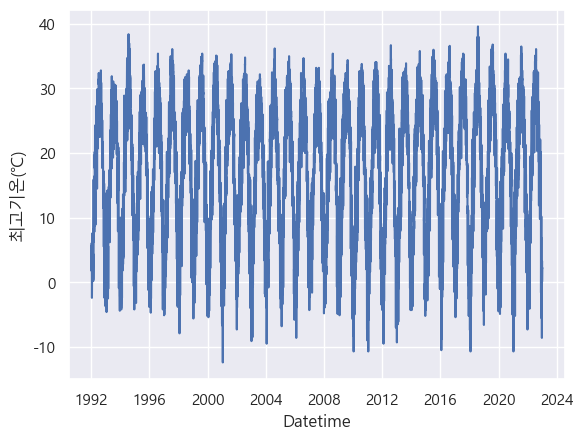

In [57]:
#Trend를 보려면? 일단 일자별, 월별 등으로 특정값의 합을 보는게 좋음

#일별 최고기온
sns.lineplot(data=df, x='Datetime',y='최고기온(℃)', estimator=sum) #estimator 옵션이 없으면 해당 일자의 평균을 계산

<Axes: xlabel='Datetime', ylabel='최고기온(℃)'>

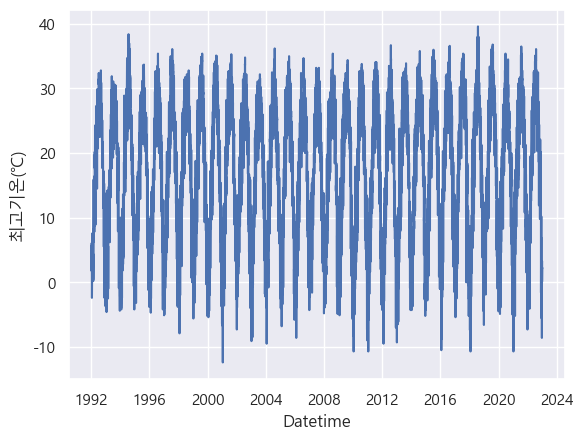

In [62]:
#위처럼 계산을 할 때 데이터의 양이 많으면 시간이 오래 걸릴 수 있음
#좀 더 빠르게 확인하는 방법은? -> pivoting 해주면 됨 -> 일별 합이 계산된 Dataframe이 나옴
p1 = pd.pivot_table(data=df, index='Datetime',values='최고기온(℃)',aggfunc='sum').reset_index()
sns.lineplot(data=p1, x='Datetime', y='최고기온(℃)')

<Axes: xlabel='Datetime', ylabel='최고기온(℃)'>

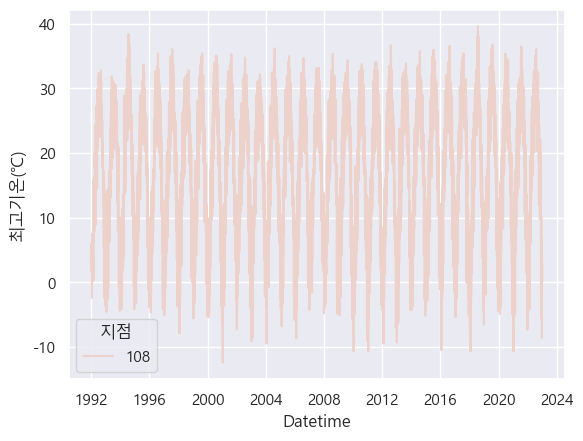

In [66]:
#지점으로 범례를 나누고 싶다면?
p2 = pd.pivot_table(data=df, index=['Datetime', '지점'],values='최고기온(℃)',aggfunc='sum').reset_index()
sns.lineplot(data=p2, x='Datetime', y='최고기온(℃)', hue='지점')

In [69]:
#특정 지점만 추출
cond1 = (df['지점']==108)
df2 = df.loc[cond1]

**ARIMA (Auto Regressive Integrated Moving Average Model)**

다음 여러가지가 조합된 것
* AR (Auto Regressive Model) : 자기회귀모델
    - 특정 시점 전의 자료가 현재에 영향을 주는 회귀 모델
    - noise에 대한 설명력이 떨어짐
    - ACF(자기상관함수) : 특정 구간 내 데이터간 상관관계를 표현 -> 제3의 요인을 고려하지 못할 수 있음(이전의 데이터가 미래의 데이터에 지속적으로 영향을 주는 경우)
    - PACF(부분자기상관함수) : 제3의 요인을 배제하고 생각

* MA (Moving Average Model) : 이동평균모델
    - 일정한 구간 데이터의 평균을 계산해 미래를 에측하는 모델
    - noise(불규칙적인 변동)을 제거할 수 있음
    
* Difference(차분)
    - 원래 시계열 분석은 정상적인 자료에만 적용이 가능(lag에 따라 평균이나 분산이 변화하지 않는 데이터)
    - 차분으로 데이터를 정상적으로 변환을 시켜줌
    
- 시계열 모델은 lag에 따른 데이터의 Trend를 분석하는 것
- 일단 데이터가 통계적으로 기술이 가능해야함(White noise 범주 안에 들어야함)
- 분석을 할 때 대표적으로 ARIMA라는 모델을 사용
- ARIMA에는 세가지 요소가 존재 AR, MR, Difference
- AR은 이전에 일어났던 일이 지금 일어나는 일에 얼마나 영향을 주는지 분석(자기회귀분석)
- AR의 단점은 변동에 대한 설명력
- 그래서 MA를 이용해 이를 보완함
- 초기에는 ARMA라는 모델의 형태로 사용했음
- 그러나 이후 Difference를 적용한 ARIMA라는 모델을 쓰면서 정상성에 대한 보정이 가능해졌음

**ARIMA Model**
- 단기예측에 적합함
- 계절적 변동요인 (주기적 변동)이 있는 경우에 사용
- Sample > 50 : 데이터 사이의 관계를 파악하기 때문에 샘플 수 가 많아야함(적은 샘플에서 노이즈가 있다면 제대로된 예측이 불가능 하므로)
- 정성적 자료를 사용해야함(시간에따른 평균과 분산의 변화 x) -> 정성적 자료가 아니라면 차분을 이용함

In [77]:
import statsmodels.tsa.api as tsa

In [73]:
df2.head()

,날짜,지점,평균기온(℃),최저기온(℃),최고기온(℃),Datetime,year,Month,Week,Day_of_week
0,1992-01-01,108,1.8,-0.7,6.0,1992-01-01,1992,1,1,Wednesday
1,1992-01-02,108,1.0,-1.5,5.1,1992-01-02,1992,1,1,Thursday
2,1992-01-03,108,-1.9,-5.0,1.8,1992-01-03,1992,1,1,Friday
3,1992-01-04,108,-2.4,-6.4,2.3,1992-01-04,1992,1,1,Saturday
4,1992-01-05,108,0.2,-2.5,2.4,1992-01-05,1992,1,1,Sunday


In [75]:
#시계열분석에서는 index가 시간에 대한 데이터인게 좋음
df_time = pd.pivot_table(data=df2, index='Datetime'
               ,values='최고기온(℃)', aggfunc='sum')
df_time.head()

,최고기온(℃)
Datetime,
1992-01-01,6.0
1992-01-02,5.1
1992-01-03,1.8
1992-01-04,2.3
1992-01-05,2.4


In [ ]:
y = df_time['최고기온(℃)'].resample('1W').mean() #1W = 일주일 단위의 평균
y.info()

In [ ]:
y.isnull().sum() #missing value가 있는지 확인
y1 = y.fillna(method='ffill') #결측치를 이전 값으로 채움 - 시계열 데이터에서는 전체 평균 보다는 bfill, ffill을 이용하는게 좋음

* 시계열 분해
    - Trend
    - Seasonality
    - Resdiual(잔차)

1. 첫번째 그래프 = 데이터를 lag 단위로 찍은 것
2. Trend = 경향으로 표현
3. Seasonal = 계절성
4. Residual = 잔차

In [ ]:
#그래프 사이즈 조정
from pylab import rcParams

rcParams['figure.figsize'] = 15,10

* 분해 시계열
    - 시계열에 영향을 주는 일반적 요인을 시계열에서 분리해 분석하는 방법 
    - 계절요인 Seasonal
    - 추세요인 Trend 
    - 순환요인 Cyclical 
    - 불규칙요인 Irregular

In [ ]:
#시계열 모델 생성
model_series = tsa.seasonal_decompose(y1, model='additive')
#모델 시각화
fig = model_series.plot()
plt.show()

In [ ]:
import itertools #반복수를 만드는 라이브러리

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q)) # p는 며칠 전의 자료가 영향을 주는지, d는 차분
seasonal_pdq = [(x[0], x[1], x[2], 31) for x in list(itertools.product(p, d, q))]

In [ ]:
seasonal_pdq # 난수로 (p,d,q)의 조합을 만든 것

In [ ]:
param_list = []
param_seasonal_list = []
results_AIC_list = []

In [ ]:
for param in pdq:
     for param_seasonal in seasonal_pdq:
        try:
            mod = tsa.statespace.SARIMAX(y1,order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            param_list.append(param)
            param_seasonal_list.append(param_seasonal)
            results_AIC_list.append(results.aic)
        except:
             continue

- **Likelihood (최대우도) : 특정 데이터가 모수로부터 추출되었을 가능도(분포의 확률을 추정)**
    - 특정 데이터가 이 분포에서 나왔을 확률!!
    - 특정값에 대한 분포의 확률 추정(연속확률밀도함수 pdf의 y값)
    
    
아래 세 지표는 모두 값이 낮을 수록 모델이 적합한 것
- **AIC (Akaike Informaion Criterion) : 데이터에 대한 모델의 상대적 품질 수준**
    - AIC = -2 ln(L) + 2k (L은 최대우도함수)
    - 값이 낮을 수록 모형 적합도가 높은 것
    
- **BIC (Bayes Information Criterion)**
    - BIC = -2 ln(L) + log(n)p 
    - AIC보다 더 많은 패널티를 부여하기에 변수가 많아질수록 AIC보다 커질 가능성이 높음
    
- **HQIC (Hannan Quin Information Criterion)**
    - HQIC = -2 ln(L) + 2k ln(ln(n))

In [ ]:
ARIMA_list = pd.DataFrame({'Parameter':param_list,'Seasonal':param_seasonal_list,'AIC':results_AIC_list})
ARIMA_list.to_excel('arima_model_list.xlsx')

In [ ]:
ARIMA_list.sort_values(by='AIC').head(2)

In [ ]:
#AIC가 가장 낮은(모형적합도가 높은) 경우로 모델 구성
#SARIMAX = 계절성이 없는 파라미터에 계절성이 있는 파라미터를 추가해 만든 모델
mod = tsa.statespace.SARIMAX(y1,order=(0, 1, 1),seasonal_order=(0, 1, 1, 12),
                              enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary())

- *Order (p,d,q), Seasonal Order (P,D,Q,M)*
    - p : AR에서의 p값 (p 구간 내 데이터 사이의 상관관계를 계산함)
    - d : 차분 (현시점 자료값 - 전시점 자료값)
    - q : MA PACF의 편상관계수 q 값
    - P : 계절성이 있는 패턴내에서의 p값(위와 동일)
    - D : 계절성 여부(1또는 0)
    - Q : ACF 함수 기준으로 계절성이 얼마나 반복되는지 횟수
    - M : 주기가 어느정도인지 나타냄

- *coef : ARIMA Model 내 회귀계수*
- *p>|z| : Ljung-Box 검정에서의 p값*

- *Ljung-Box 검정 : 일정 기간 동안 관측치가 랜덤이고, 독립적인지 여부를 검정*
    - 귀무 가설 : 데이터가 상관관계를 나타내지 않는다.
    - 대립 가설 : 데이터가 상관관계를 나타낸다.(상관계수가 0이 아니다)
    - p.value(귀무가설이 참일 확률) < 0.05 (유의수준)
    
- *Heteroskedasticity : 이분산 검정 = 잔차의 분산이 일치한지 검정 (P<0.05 : 등분산)*

- *Jarque Bera 검정 : 왜도(한쪽으로 쏠린 정도)와 첨도(뾰족한 정도)가 정규분포와 일치하는지 가설 검정*
    - SARIMAX의 잔차의 분포가 정규분포인가?를 검정
    - 귀무가설 : 해당 잔차(residual)은 정규분포와 일치한다.
    - 대립 가설 : 해당 잔차(residual)은 정규분포와 일치하지 않는다. = Trend가 있다!(회귀분석에서는 잔차가 정규분포를 띠어야함)
    - Skew : 왜도
    - Kurtosis : 첨도

**잔차**
- 잔차는 실제값과 예측값 사이 차이 : 잔차가 작다 = 모델이 데이터를 잘 설명한다

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()